In [1]:
import json
import random
from tqdm import tqdm
import numpy as np

from matplotlib import pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

import torch

from pylab import rcParams
rcParams['figure.figsize'] = 15, 15

# Что делать?
Где есть пометка # CODE писать код

[Полезный туториал](http://jalammar.github.io/illustrated-word2vec/)

# Загружаем данные
Они уже обработанные и токенизированные. Процесс можно посмотреть в тетрадке 1.1 Processing corpus

In [36]:
with open('processed_corpus.json') as f:
    corpus = json.load(f)

In [3]:
len(corpus)

100000

In [ ]:
for text in corpus[:5]:
    print(' '.join(text))

второй UNK год окончательно разочаровать решить податься альфабанк
вернуть денежный средство лицевой счёт либо зачесть счёт погашение кредит
притом ситуация решиться участие течение сутки заявить
мой ##число летний жизнь это самый неповоротливый работник банк который видеть
везде написать вклад принимать очередь это


# CBOW

In [ ]:
sample_text = corpus[0]

In [ ]:
' '.join(sample_text)

'второй UNK год окончательно разочаровать решить податься альфабанк'

# Реализуйте разделение предложения на примеры методом CBOW

In [ ]:
def cbow_split(tokens, window, pad_token='PAD'):
    
    splits = []
    #CODE
    padding = [pad_token]*2
    tokens = padding + tokens + padding
    for i in range(window, len(tokens)-window):
      center = tokens[i]
      left = tokens[i-window:i]
      right = tokens[i+1:i+1+window]
      split = (left, center, right)
      splits.append(split)

    return splits

In [ ]:
splits = cbow_split(sample_text, window=2)

In [ ]:
for sample in splits:
    print('Левый контекст:', sample[0])
    print('Центральное слово:', sample[1])
    print('Правый контекст:', sample[2], end='\n\n')

Левый контекст: ['PAD', 'PAD']
Центральное слово: второй
Правый контекст: ['UNK', 'год']

Левый контекст: ['PAD', 'второй']
Центральное слово: UNK
Правый контекст: ['год', 'окончательно']

Левый контекст: ['второй', 'UNK']
Центральное слово: год
Правый контекст: ['окончательно', 'разочаровать']

Левый контекст: ['UNK', 'год']
Центральное слово: окончательно
Правый контекст: ['разочаровать', 'решить']

Левый контекст: ['год', 'окончательно']
Центральное слово: разочаровать
Правый контекст: ['решить', 'податься']

Левый контекст: ['окончательно', 'разочаровать']
Центральное слово: решить
Правый контекст: ['податься', 'альфабанк']

Левый контекст: ['разочаровать', 'решить']
Центральное слово: податься
Правый контекст: ['альфабанк', 'PAD']

Левый контекст: ['решить', 'податься']
Центральное слово: альфабанк
Правый контекст: ['PAD', 'PAD']



In [ ]:
splits

[(['PAD', 'PAD'], 'второй', ['UNK', 'год']),
 (['PAD', 'второй'], 'UNK', ['год', 'окончательно']),
 (['второй', 'UNK'], 'год', ['окончательно', 'разочаровать']),
 (['UNK', 'год'], 'окончательно', ['разочаровать', 'решить']),
 (['год', 'окончательно'], 'разочаровать', ['решить', 'податься']),
 (['окончательно', 'разочаровать'], 'решить', ['податься', 'альфабанк']),
 (['разочаровать', 'решить'], 'податься', ['альфабанк', 'PAD']),
 (['решить', 'податься'], 'альфабанк', ['PAD', 'PAD'])]

# Expected

```python
[(['PAD', 'PAD'], 'вопрос', ['почему', 'например']),
 (['PAD', 'вопрос'], 'почему', ['например', 'китайский']),
 (['вопрос', 'почему'], 'например', ['китайский', 'японский']),
 (['почему', 'например'], 'китайский', ['японский', 'UNK']),
 (['например', 'китайский'], 'японский', ['UNK', 'PAD']),
 (['китайский', 'японский'], 'UNK', ['PAD', 'PAD'])]
```

In [ ]:
cbow_split(sample_text, window=3)

[(['PAD', 'PAD', 'второй'], 'UNK', ['год', 'окончательно', 'разочаровать']),
 (['PAD', 'второй', 'UNK'], 'год', ['окончательно', 'разочаровать', 'решить']),
 (['второй', 'UNK', 'год'],
  'окончательно',
  ['разочаровать', 'решить', 'податься']),
 (['UNK', 'год', 'окончательно'],
  'разочаровать',
  ['решить', 'податься', 'альфабанк']),
 (['год', 'окончательно', 'разочаровать'],
  'решить',
  ['податься', 'альфабанк', 'PAD']),
 (['окончательно', 'разочаровать', 'решить'],
  'податься',
  ['альфабанк', 'PAD', 'PAD'])]

# Expected

```python
[(['PAD', 'PAD', 'PAD'], 'вопрос', ['почему', 'например', 'китайский']),
 (['PAD', 'PAD', 'вопрос'], 'почему', ['например', 'китайский', 'японский']),
 (['PAD', 'вопрос', 'почему'], 'например', ['китайский', 'японский', 'UNK']),
 (['вопрос', 'почему', 'например'], 'китайский', ['японский', 'UNK', 'PAD']),
 (['почему', 'например', 'китайский'], 'японский', ['UNK', 'PAD', 'PAD']),
 (['например', 'китайский', 'японский'], 'UNK', ['PAD', 'PAD', 'PAD'])]
```

# Skipgram

In [ ]:
' '.join(sample_text)

'второй UNK год окончательно разочаровать решить податься альфабанк'

# Реализуйте разделение предложения на примеры методом Skipgram

In [2]:
def skipgram_split(tokens, window):
    
    splits = []
    
    # CODE
    for i, center in enumerate(tokens):
        left = max(i-window, 0)
        right = min(i+window+1, len(tokens))
        left_context = tokens[left:i]
        right_context = tokens[i+1:right]
        full_context = left_context + right_context
        for context in full_context:
            splits.append((context, center))
    
    return splits

In [ ]:
splits = skipgram_split(sample_text, window=2)

In [ ]:
splits

[('UNK', 'второй'),
 ('год', 'второй'),
 ('второй', 'UNK'),
 ('год', 'UNK'),
 ('окончательно', 'UNK'),
 ('второй', 'год'),
 ('UNK', 'год'),
 ('окончательно', 'год'),
 ('разочаровать', 'год'),
 ('UNK', 'окончательно'),
 ('год', 'окончательно'),
 ('разочаровать', 'окончательно'),
 ('решить', 'окончательно'),
 ('год', 'разочаровать'),
 ('окончательно', 'разочаровать'),
 ('решить', 'разочаровать'),
 ('податься', 'разочаровать'),
 ('окончательно', 'решить'),
 ('разочаровать', 'решить'),
 ('податься', 'решить'),
 ('альфабанк', 'решить'),
 ('разочаровать', 'податься'),
 ('решить', 'податься'),
 ('альфабанк', 'податься'),
 ('решить', 'альфабанк'),
 ('податься', 'альфабанк')]

In [ ]:
for sample in splits:
    print('Контекст:', sample[0])
    print('Центральное слово:', sample[1], end='\n\n')

Контекст: UNK
Центральное слово: второй

Контекст: год
Центральное слово: второй

Контекст: второй
Центральное слово: UNK

Контекст: год
Центральное слово: UNK

Контекст: окончательно
Центральное слово: UNK

Контекст: второй
Центральное слово: год

Контекст: UNK
Центральное слово: год

Контекст: окончательно
Центральное слово: год

Контекст: разочаровать
Центральное слово: год

Контекст: UNK
Центральное слово: окончательно

Контекст: год
Центральное слово: окончательно

Контекст: разочаровать
Центральное слово: окончательно

Контекст: решить
Центральное слово: окончательно

Контекст: год
Центральное слово: разочаровать

Контекст: окончательно
Центральное слово: разочаровать

Контекст: решить
Центральное слово: разочаровать

Контекст: податься
Центральное слово: разочаровать

Контекст: окончательно
Центральное слово: решить

Контекст: разочаровать
Центральное слово: решить

Контекст: податься
Центральное слово: решить

Контекст: альфабанк
Центральное слово: решить

Контекст: разочароват

In [ ]:
skipgram_split(sample_text, window=2)

[('UNK', 'второй'),
 ('год', 'второй'),
 ('второй', 'UNK'),
 ('год', 'UNK'),
 ('окончательно', 'UNK'),
 ('второй', 'год'),
 ('UNK', 'год'),
 ('окончательно', 'год'),
 ('разочаровать', 'год'),
 ('UNK', 'окончательно'),
 ('год', 'окончательно'),
 ('разочаровать', 'окончательно'),
 ('решить', 'окончательно'),
 ('год', 'разочаровать'),
 ('окончательно', 'разочаровать'),
 ('решить', 'разочаровать'),
 ('податься', 'разочаровать'),
 ('окончательно', 'решить'),
 ('разочаровать', 'решить'),
 ('податься', 'решить'),
 ('альфабанк', 'решить'),
 ('разочаровать', 'податься'),
 ('решить', 'податься'),
 ('альфабанк', 'податься'),
 ('решить', 'альфабанк'),
 ('податься', 'альфабанк')]

# Expected

```python
[('почему', 'вопрос'),
 ('например', 'вопрос'),
 ('вопрос', 'почему'),
 ('например', 'почему'),
 ('китайский', 'почему'),
 ('вопрос', 'например'),
 ('почему', 'например'),
 ('китайский', 'например'),
 ('японский', 'например'),
 ('почему', 'китайский'),
 ('например', 'китайский'),
 ('японский', 'китайский'),
 ('UNK', 'китайский'),
 ('например', 'японский'),
 ('китайский', 'японский'),
 ('UNK', 'японский'),
 ('китайский', 'UNK'),
 ('японский', 'UNK')]
```

In [ ]:
skipgram_split(sample_text, window=3)

[('UNK', 'второй'),
 ('год', 'второй'),
 ('окончательно', 'второй'),
 ('второй', 'UNK'),
 ('год', 'UNK'),
 ('окончательно', 'UNK'),
 ('разочаровать', 'UNK'),
 ('второй', 'год'),
 ('UNK', 'год'),
 ('окончательно', 'год'),
 ('разочаровать', 'год'),
 ('решить', 'год'),
 ('второй', 'окончательно'),
 ('UNK', 'окончательно'),
 ('год', 'окончательно'),
 ('разочаровать', 'окончательно'),
 ('решить', 'окончательно'),
 ('податься', 'окончательно'),
 ('UNK', 'разочаровать'),
 ('год', 'разочаровать'),
 ('окончательно', 'разочаровать'),
 ('решить', 'разочаровать'),
 ('податься', 'разочаровать'),
 ('альфабанк', 'разочаровать'),
 ('год', 'решить'),
 ('окончательно', 'решить'),
 ('разочаровать', 'решить'),
 ('податься', 'решить'),
 ('альфабанк', 'решить'),
 ('окончательно', 'податься'),
 ('разочаровать', 'податься'),
 ('решить', 'податься'),
 ('альфабанк', 'податься'),
 ('разочаровать', 'альфабанк'),
 ('решить', 'альфабанк'),
 ('податься', 'альфабанк')]

# Expected

```python
[('почему', 'вопрос'),
 ('например', 'вопрос'),
 ('китайский', 'вопрос'),
 ('вопрос', 'почему'),
 ('например', 'почему'),
 ('китайский', 'почему'),
 ('японский', 'почему'),
 ('вопрос', 'например'),
 ('почему', 'например'),
 ('китайский', 'например'),
 ('японский', 'например'),
 ('UNK', 'например'),
 ('вопрос', 'китайский'),
 ('почему', 'китайский'),
 ('например', 'китайский'),
 ('японский', 'китайский'),
 ('UNK', 'китайский'),
 ('почему', 'японский'),
 ('например', 'японский'),
 ('китайский', 'японский'),
 ('UNK', 'японский'),
 ('например', 'UNK'),
 ('китайский', 'UNK'),
 ('японский', 'UNK')]
```

Это и некоторые другие вещи, типа обучения модели, я обернул в функции, чтобы проще потом было использовать при экспериментах

In [3]:
def get_word2index(path='processed_corpus.json'):

  word2index = {}

  with open(path) as f:
    corpus = json.load(f)
  
  for text in corpus:
    for token in text:
      if token not in word2index:
        word2index[token] = len(word2index)
  
  return word2index

In [37]:
word2index = get_word2index()

In [6]:
len(word2index)

13076

In [7]:
word2index['UNK']

1

In [8]:
[word2index[tok] if tok in word2index else word2index['UNK'] for tok in 'мама мыть рама'.split()]

[1282, 8436, 1]

# Torch Dataset
В торче есть очень удобная читалка данных

In [4]:
from torch.utils.data import Dataset, DataLoader

In [ ]:
# игрушечный датасет
# 121535 примера, 4 фичи, 3 класса
some_data_x = np.random.rand(121535, 4)
some_data_y = np.random.randint(3, size=(121535,))

In [ ]:
# соверешенно игрушечный, просто цифры
some_data_x[:10]

array([[0.80763932, 0.70000794, 0.08786041, 0.15615916],
       [0.16952997, 0.47373278, 0.6171898 , 0.25251959],
       [0.57328739, 0.46611352, 0.64594597, 0.89625784],
       [0.0590957 , 0.36445452, 0.62500675, 0.1118449 ],
       [0.66597543, 0.06839245, 0.34237243, 0.91512317],
       [0.46371213, 0.62554359, 0.01332552, 0.67483071],
       [0.15071175, 0.27628772, 0.64633953, 0.4587506 ],
       [0.36412671, 0.2795205 , 0.60432103, 0.17327947],
       [0.64176477, 0.86385814, 0.86976857, 0.95143235],
       [0.3227515 , 0.93697474, 0.19408151, 0.73823143]])

In [ ]:
some_data_y

array([2, 1, 0, ..., 2, 1, 2])

In [ ]:
class ToyDataset(Dataset):
    
    def __init__(self, data_x, data_y):
        
        super().__init__()
        
        self.data_x = data_x
        self.data_y = data_y
        
    def __len__(self):
        
        # Нужно обязательно определить эту функцию
        # Должна возвращать размер датасета
        
        return len(self.data_x)
    
    def __getitem__(self, idx):
        
        # Еще нужно определить этот метод
        # То есть как мы будем доставать наши данные по индексу
        
        return self.data_x[idx], self.data_y[idx]

In [ ]:
some_dataset = ToyDataset(some_data_x, some_data_y)

In [ ]:
some_dataset[5], some_dataset[467]

((array([0.46371213, 0.62554359, 0.01332552, 0.67483071]), 2),
 (array([0.65352849, 0.26169994, 0.51280673, 0.20233653]), 0))

In [ ]:
some_loader = DataLoader(some_dataset, batch_size=16, shuffle=True)

In [ ]:
for x, y in some_loader:
    break
    
len(x), x

(16, tensor([[0.0912, 0.9040, 0.8419, 0.3865],
         [0.8889, 0.0763, 0.7034, 0.2864],
         [0.3969, 0.6151, 0.8696, 0.0746],
         [0.4180, 0.9891, 0.5861, 0.5383],
         [0.3807, 0.7938, 0.6785, 0.7255],
         [0.4778, 0.2167, 0.2917, 0.0697],
         [0.7829, 0.4661, 0.3769, 0.6277],
         [0.6035, 0.8709, 0.4871, 0.2002],
         [0.3345, 0.1266, 0.3873, 0.1573],
         [0.6202, 0.9935, 0.6827, 0.2273],
         [0.6765, 0.9771, 0.9016, 0.4413],
         [0.6801, 0.3531, 0.9752, 0.7508],
         [0.6724, 0.6285, 0.6237, 0.9349],
         [0.1133, 0.3670, 0.3482, 0.9445],
         [0.6212, 0.9264, 0.7261, 0.0546],
         [0.6711, 0.5993, 0.1075, 0.2664]], dtype=torch.float64))

In [ ]:
for x, y in some_loader:
    pass

len(x)

15

In [ ]:
# почему 13?
# потому что количество наших данных нацело не делится на 16
# и поэтому последний батч меньше 16-ти
len(some_dataset) % 16

15

# А зачем?

In [ ]:
class ToyDataset(Dataset):
    
    def __init__(self, data_x, data_y):
        
        super().__init__()
        
        self.data_x = data_x
        self.data_y = data_y
        
    def __len__(self):
        
        # Нужно обязательно определить эту функцию
        # Должна возвращать размер датасета
        
        return len(self.data_x)
    
    @staticmethod
    def add_pow_features(x, n=2):
        
        return np.concatenate([x, x ** n]) 
    
    @staticmethod
    def add_log_features(x):
        
        return np.concatenate([x, np.log(x)]) 
    
    def __getitem__(self, idx):
        
        # Еще нужно определить этот метод
        # То есть как мы будем доставать наши данные по индексу
        
        x = self.data_x[idx]
        
        # внутри датасета мы можем делать все что угодно с нашими данными
        # например выше определим функции, которые добавляют степенные фичи
        x = self.add_pow_features(x, n=2)
        x = self.add_pow_features(x, n=3)
        # и еще возьмем логарифмические фичи
        x = self.add_log_features(x)
        
        y = self.data_y[idx]
        
        return x, y

In [ ]:
toy_dataset = ToyDataset(some_data_x, some_data_y)

In [ ]:
toy_loader = DataLoader(dataset=toy_dataset, batch_size=128)

In [ ]:
for x, y in toy_loader:
    break

In [ ]:
x.shape

torch.Size([128, 32])

In [ ]:
# заметим, что мы сразу получаем торчовый формат данных
x

tensor([[ 8.0764e-01,  7.0001e-01,  8.7860e-02,  ..., -2.1400e+00,
         -1.4592e+01, -1.1141e+01],
        [ 1.6953e-01,  4.7373e-01,  6.1719e-01,  ..., -4.4827e+00,
         -2.8955e+00, -8.2576e+00],
        [ 5.7329e-01,  4.6611e-01,  6.4595e-01,  ..., -4.5800e+00,
         -2.6222e+00, -6.5716e-01],
        ...,
        [ 3.7118e-01,  9.3891e-01,  1.5279e-02,  ..., -3.7820e-01,
         -2.5088e+01, -3.7898e-01],
        [ 8.0628e-01,  7.2011e-01,  7.2882e-01,  ..., -1.9701e+00,
         -1.8980e+00, -8.5226e+00],
        [ 4.2888e-01,  5.4273e-01,  6.9399e-01,  ..., -3.6669e+00,
         -2.1918e+00, -5.9809e-01]], dtype=torch.float64)

In [ ]:
y

tensor([2, 1, 0, 2, 0, 2, 2, 2, 1, 0, 2, 2, 1, 1, 2, 1, 1, 1, 2, 0, 2, 0, 1, 2,
        2, 0, 2, 2, 1, 1, 0, 2, 0, 0, 2, 0, 2, 1, 0, 2, 2, 2, 2, 1, 0, 1, 0, 2,
        2, 2, 0, 2, 2, 1, 2, 1, 2, 2, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 2, 0, 2, 2,
        2, 2, 0, 2, 2, 0, 2, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 2, 1, 2, 0, 1, 1, 1,
        2, 1, 1, 2, 2, 1, 2, 2, 0, 2, 0, 0, 0, 2, 1, 0, 0, 1, 1, 0, 1, 2, 0, 0,
        1, 2, 0, 0, 0, 1, 2, 1])

# Если вы ничего здесь не понимаете, то вернитесь в конец первой домашки, там все объясняется

In [ ]:
model = torch.nn.Sequential(torch.nn.Linear(32, 16),
                            torch.nn.ReLU(),
                            torch.nn.Linear(16, 8),
                            torch.nn.ReLU(),
                            torch.nn.Linear(8, 3))

criterion = torch.nn.CrossEntropyLoss()

In [ ]:
with torch.no_grad():

    prediction = model(x.float())

    loss = criterion(prediction, y)
    
loss.item()

1.1333441734313965

# Боевые датасеты

In [ ]:
class CBOWDataset(Dataset):

    def __init__(self,
                 corpus,
                 word2index,
                 window=2,
                 unk_token='UNK',
                 pad_token='PAD',
                 collect_verbose=True):

        self.corpus = corpus
        self.word2index = word2index
        self.index2word = {value: key for key, value in self.word2index.items()}
        self.window = window

        self.unk_token = unk_token
        self.unk_index = self.word2index[self.unk_token]

        self.pad_token = pad_token
        self.pad_index = len(self.word2index)

        self.collect_verbose = collect_verbose

        self.data = []

        self.collect_data()

    def __len__(self):

        return len(self.data)

    def _split_function(self, tokenized_text):

        splits = []

        for n in range(len(tokenized_text)):
            left_context = tokenized_text[np.maximum(n - self.window, 0):n]
            left_context = ([self.pad_index] * (self.window - len(left_context))) + left_context

            central_word = tokenized_text[n]

            right_context = tokenized_text[n + 1:n + self.window + 1]
            right_context = right_context + ([self.pad_index] * (self.window - len(right_context)))

            splits.append((left_context + right_context, central_word))

        return splits

    def indexing(self, tokenized_text):

        return [self.word2index[token] if token in self.word2index else self.unk_index for token in tokenized_text]

    def collect_data(self):

        corpus = tqdm(self.corpus, disable=not self.collect_verbose)

        for tokenized_text in corpus:
            indexed_text = self.indexing(tokenized_text)
            cbow_examples = self._split_function(indexed_text)

            self.data.extend(cbow_examples)

    def __getitem__(self, idx):

        context, central_word = self.data[idx]

        context = torch.Tensor(context).long()

        return context, central_word

# Мы будем учить модель Skipgram
Реализуйте читалку данных

In [5]:
class SkipgramDataset(Dataset):

    def __init__(self,
                 corpus,
                 word2index,
                 window=4,
                 unk_token='UNK',
                 collect_verbose=True):
        self.corpus = corpus
        self.word2index = word2index
        self.index2word = {value: key for key, value in self.word2index.items()}
        self.window = window

        self.unk_token = unk_token
        self.unk_index = self.word2index[self.unk_token]
        

        self.collect_verbose = collect_verbose

        self.data = []

        self.collect_data()

    def __len__(self):

        return len(self.data)

    def _split_function(self, tokenized_text):
      #CODE
      splits = []

      for i, center in enumerate(tokenized_text):
        left = max(i-self.window, 0)
        right = min(i+self.window+1, len(tokenized_text))
        left_context = tokenized_text[left:i]
        right_context = tokenized_text[i+1:right]
        full_context = left_context + right_context
        
        for context in full_context:
          splits.append((context, center))
      
      return splits

    def indexing(self, tokenized_text):

        return [self.word2index[token] if token in self.word2index else self.unk_index for token in tokenized_text]

    def collect_data(self):

        corpus = tqdm(self.corpus, disable=not self.collect_verbose)

        for tokenized_text in corpus:
            indexed_text = self.indexing(tokenized_text)
            skipgram_examples = self._split_function(indexed_text)

            self.data.extend(skipgram_examples)

    def __getitem__(self, idx):
        
        # CODE
        context, central_word = self.data[idx]

        return context, central_word

In [ ]:
# можете положить SkipgramDataset в отдельный файлик, например word2vec_utils и относительным импортом достать его 
#from .word2vec_utils import SkipgramDataset

In [38]:
dataset = SkipgramDataset(corpus, word2index)

100%|██████████| 100000/100000 [00:02<00:00, 34012.33it/s]


In [39]:
BATCH_SIZE = 512

In [40]:
dataset_loader = DataLoader(dataset, shuffle=True, batch_size=BATCH_SIZE)

In [41]:
for x, y in dataset_loader:
    break

In [42]:
x[:5]

tensor([ 198, 1419,   32, 3350, 2198])

In [43]:
y[:5]

tensor([ 531,  486,  413, 1557, 1564])

In [44]:
x.shape, y.shape

(torch.Size([512]), torch.Size([512]))

In [ ]:
class CBOW(torch.nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, pad_index):
        
        super().__init__()
        
        if pad_index > 0:
            vocab_size += 1
        
        self.in_embedding = torch.nn.Embedding(num_embeddings=vocab_size, 
                                               embedding_dim=embedding_dim,
                                               padding_idx=pad_index)
        
        self.out_embedding = torch.nn.Linear(in_features=embedding_dim,
                                             out_features=vocab_size, bias=False)
        
    def forward(self, x):
        
        x = self.in_embedding(x).sum(dim=-2)
        x = self.out_embedding(x)
        
        return x

# Мы будем учить модель Skipgram
Реализуйте ее

In [15]:
# CODE
class SkipGram(torch.nn.Module):

  def __init__(self, vocab_size, embedding_dim):
    
    super().__init__()
    
    self.in_embedding = torch.nn.Embedding(num_embeddings=vocab_size, 
                                               embedding_dim=embedding_dim)
    
    self.out_embedding = torch.nn.Linear(in_features=embedding_dim,
                                             out_features=vocab_size, bias=False)
  def forward(self,x):
    x = self.in_embedding(x)
    x = self.out_embedding(x)

    return x

In [ ]:
#from word2vec_utils import SkipGram

In [34]:
# размерность эмбеддинга
# маленькая, чтобы мы могли недолго поучить ворд2век и увидеть результаты
EMBEDDING_DIM = 20

In [49]:
model = SkipGram(vocab_size=len(word2index), embedding_dim=EMBEDDING_DIM)

In [46]:
with torch.no_grad():
    pred = model(x)

pred.shape

torch.Size([512, 13076])

In [47]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001)

# aka loss function
criterion = torch.nn.CrossEntropyLoss()

# Допишите обучалку

In [33]:
def train_model(model=model,
                epochs=3,
                optimizer=optimizer,
                dataset_loader=dataset_loader):
  
  criterion = torch.nn.CrossEntropyLoss()
  losses = []

  for n_epoch in range(epochs):
    try:
      progress_bar = tqdm(total=len(dataset_loader.dataset), desc='Epoch {}'.format(n_epoch + 1))
      
      for x, y in dataset_loader:
        # CODE
        pred = model(x)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        progress_bar.set_postfix(loss=np.mean(losses[-100:]))
        progress_bar.update(x.shape[0])
      progress_bar.close()
    except KeyboardInterrupt:
      progress_bar.close()
      break
    
  return losses

In [22]:
losses = train_model()

Epoch 3: 100%|██████████| 5166680/5166680 [15:23<00:00, 5592.31it/s, loss=7.21]


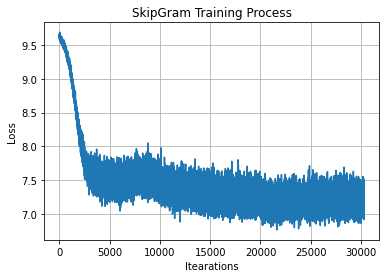

In [23]:
plt.title('SkipGram Training Process')
plt.xlabel('Itearations')
plt.ylabel('Loss')
plt.grid()
plt.plot(losses)

In [24]:
# проверка, что хоть что-то выучилось
assert np.mean(losses[-1000:]) < 7.5

In [25]:
embedding_matrix = model.in_embedding.weight.detach()

In [27]:
def cos_sim(embedding_matrix, token2id, word1, word2):
    
    i1 = token2id[word1]
    i2 = token2id[word2]
    
    v1, v2 = embedding_matrix[i1], embedding_matrix[i2]
    
    v1_n = v1.div(v1.norm(keepdim=True))
    v2_n = v2.div(v2.norm(keepdim=True))
    
    similarity = torch.dot(v1_n, v2_n).item()
    
    return similarity

# Косинусная близость
От 0 до 1, где 0 - вектора абсолютно разные, где 1 - идентичные.

In [27]:
cos_sim(embedding_matrix, word2index, 'день', 'месяц')

0.7578384876251221

In [28]:
cos_sim(embedding_matrix, word2index, 'минута', 'месяц')

0.61942058801651

In [29]:
cos_sim(embedding_matrix, word2index, 'сотрудник', 'сотрудница')

0.8436672687530518

In [30]:
cos_sim(embedding_matrix, word2index, 'вклад', 'перевод')

0.5593034029006958

In [31]:
random_word = random.choice(list(word2index.keys()))
sim = cos_sim(embedding_matrix, word2index, 'день', random_word)
'Косинусная близость слова "день" к случайному выбраному слову "{}" равна {:.3f}'.format(random_word, sim)

'Косинусная близость слова "день" к случайному выбраному слову "разозлить" равна 0.166'

In [32]:
freq = {}

for text in corpus:
    for token in text:
        if token in freq:
            freq[token] += 1
        else:
            freq[token] = 1

In [33]:
sorted_freq = [(k, freq[k]) for k in sorted(freq, key=freq.get, reverse=True)]
top_sorted_freq = sorted_freq[0:200]

In [34]:
tsne = TSNE(n_components=2, init='pca', random_state=42, verbose=2)
reduced = tsne.fit_transform(embedding_matrix)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 13076 samples in 0.038s...
[t-SNE] Computed neighbors for 13076 samples in 8.523s...
[t-SNE] Computed conditional probabilities for sample 1000 / 13076
[t-SNE] Computed conditional probabilities for sample 2000 / 13076
[t-SNE] Computed conditional probabilities for sample 3000 / 13076
[t-SNE] Computed conditional probabilities for sample 4000 / 13076
[t-SNE] Computed conditional probabilities for sample 5000 / 13076
[t-SNE] Computed conditional probabilities for sample 6000 / 13076
[t-SNE] Computed conditional probabilities for sample 7000 / 13076
[t-SNE] Computed conditional probabilities for sample 8000 / 13076
[t-SNE] Computed conditional probabilities for sample 9000 / 13076
[t-SNE] Computed conditional probabilities for sample 10000 / 13076
[t-SNE] Computed conditional probabilities for sample 11000 / 13076
[t-SNE] Computed conditional probabilities for sample 12000 / 13076
[t-SNE] Computed conditional probabilities for sam

In [35]:
top_words = [a for a,_ in top_sorted_freq]

In [36]:
inds = [word2index[word] for word in top_words]
x_coords = [coords[0] for coords in reduced[inds]]
y_coords = [coords[1] for coords in reduced[inds]]

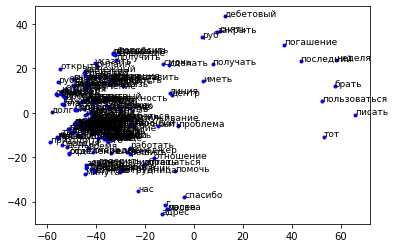

In [37]:
for (x, y, word) in zip(x_coords, y_coords, top_words):
    plt.scatter(x, y, marker='.', color='blue')
    plt.text(x+0.01, y+0.01, word, fontsize=9)
plt.show()

# Оценка качества эмбеддингов

In [7]:
import pandas as pd

evaluation_df = pd.read_csv('ru_simlex965_tagged.tsv', delimiter='\t')

In [8]:
evaluation_df['# Word1'] = evaluation_df.apply(lambda row: row['# Word1'].split('_')[0],axis=1)
evaluation_df['Word2'] = evaluation_df.apply(lambda row: row['Word2'].split('_')[0],axis=1)

In [9]:
evaluation_df['Average Score']=((evaluation_df['Average Score']-evaluation_df['Average Score'].min())/(evaluation_df['Average Score'].max()-evaluation_df['Average Score'].min()))*1

In [25]:
def get_scores(word1_column='# Word1',
               word2_column='Word2',
               df=evaluation_df,
               embedding_matrix=embedding_matrix,
               word2index=word2index):
  sim_scores = []
  words = list(word2index.keys())
  for i in range(0, len(df)):
    if df[word1_column][i] in words and df[word2_column][i] in words:
      sim_score = cos_sim(embedding_matrix, word2index, 
                          df[word1_column][i],df[word2_column][i])
      sim_scores.append(sim_score)
    else:
      # Многих слов из тестового датасета просто нет в модели
      sim_scores.append(None)

  return np.array(sim_scores)


def get_mse(y_pred, y_true):
  difference_array = np.subtract(y_pred, y_true)
  squared_array = np.square(difference_array)
  mse = squared_array.mean()

  return mse

In [43]:
y_true = np.array(evaluation_df['Average Score'].tolist())
y_pred = get_scores()

In [44]:
none_indexes = np.where(y_pred == None)[0]

Оставим только скоры слов, которые есть в предсказанных

In [45]:
y_true = np.delete(y_true, none_indexes)
y_pred = np.delete(y_pred, none_indexes)

In [46]:
mse = get_mse(y_pred, y_true)
mse

0.1279378151458604

In [47]:
rmse = np.sqrt(mse)
rmse

0.3576839598666124

# Эксперименты

Я уменьшил порог удаления редких слов до 5, увеличил размер корпуса до 150 000. Воспользовался MyStem3 вместо PyMorphy2 для лемматизации (вроде MyStem лучше лемметизирует + его начальная форма глаголов больше похожа на ту которая в таблице с которой сравниваем).

Файл нового корпуса и измененная тетрадка с препроцом лежат в репозитории с домашкой.

In [11]:
with open('new_processed_corpus.json') as f:
    corpus = json.load(f)

In [12]:
word2index = get_word2index('new_processed_corpus.json')

In [13]:
dataset_2 = SkipgramDataset(corpus, word2index)
BATCH_SIZE = 512
dataset_loader_2 = DataLoader(dataset_2, shuffle=True, batch_size=BATCH_SIZE)
for x, y in dataset_loader:
    break
x.shape, y.shape

100%|██████████| 150000/150000 [00:04<00:00, 35133.50it/s]


(torch.Size([512]), torch.Size([512]))

In [18]:
EMBEDDING_DIM = 20

In [20]:
model_2 = SkipGram(vocab_size=len(word2index), embedding_dim=EMBEDDING_DIM)
with torch.no_grad():
    pred = model_2(x)

pred.shape

torch.Size([512, 18763])

In [21]:
optimizer = torch.optim.Adam(params=model_2.parameters(), lr=0.0001)

# aka loss function
criterion = torch.nn.CrossEntropyLoss()

In [23]:
losses = train_model(model=model_2, epochs=3)

Epoch 3: 100%|██████████| 7759964/7759964 [35:58<00:00, 3594.24it/s, loss=7.32]


In [24]:
embedding_matrix = model.in_embedding.weight.detach()

In [50]:
y_true = np.array(evaluation_df['Average Score'].tolist())
y_pred = get_scores()

In [29]:
none_indexes = np.where(y_pred == None)[0]

In [30]:
y_true = np.delete(y_true, none_indexes)
y_pred = np.delete(y_pred, none_indexes)

In [31]:
mse = get_mse(y_pred, y_true)
mse

0.11626969208357466

In [32]:
rmse = np.sqrt(mse)
rmse

0.34098341907426327

В целом, стало чуть-чуть лучше. Кажется даже, что в-первую очередь на это повлияло увеличения размера корпуса (так как часто получалось и продолжает получаться, что некоторых слов из таблицы с которой сравниваем, просто нет в модели). 

Если говорить про понижение threshold'а, то кажется не стоило понижать его до 5, а надо было до 10 (5 кажется слишком мало и мб это еще наряду с увеличением корпуса сильно повысило время обучения).

# Оценка
1. Вы добрались сюда и все работает, значит уже получили 7 баллов.
2. 8 баллов - Взяли корпус для оценка качества эмбеддингов [здесь](https://rusvectores.org/static/testsets/ru_simlex965_tagged.tsv). Описание к нему [здесь](https://arxiv.org/pdf/1801.06407.pdf). Его английская версия для понимания, того что же это такое [тут](https://fh295.github.io/simlex.html). Если в кратце - он похож а гугл аналогии, просто иначе составлен. Определили качество своих эмбеддингов. Как качество измерить? Можете все значения отнормировать (привести к 1) и затем считать MSE между тем что у вас и что в оригинале.
3. 9 баллов - Поставили эксперименты, поменяли любые параметры, хоть корпус увеличили или как то почистили. Показали метрики до и после. После должно быть лучше, иначе это все еще 8 баллов.
4. 10 баллов - удивили своим подходом (или просто удивили) пока делили на 9 баллов